# Using a Neural Networkt recognize execution patterns using hardware performance counters

Load libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.utils import to_categorical
import seaborn as sns
dataset = pd.read_csv('patterns.csv',sep=';')
dataset_NAS = pd.read_csv('NAS-clean.csv',sep=';')

Using TensorFlow backend.


Shuffle data, necessary to mix the rows in the dataset in order to have training and testing data with all the cases.
If the data is not shuffled, the cur for the test7train pair will be done at exacty the x-th position in the dataset.

In [2]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)
print('first:', dataset['label'].unique())
print('other:', dataset_NAS['label'].unique())

first: ['Triad' 'Scale' '2D4PStencil' 'Add' 'Scatter' 'Stride2' '2PStencil'
 'Copy' 'Rows' 'Reduction' 'Stride4' 'Stride64' 'Gather' 'Test' 'Stride16']
other: ['Add_BT' 'Triad_BT' 'Triad_Red_rhorr' 'Triad_similar_qAp'
 'Triad_multi_z_alpha_p' 'Triad_pr_beta_p' 'Triad_norm_temps'
 'Scale_normztox' 'Triad_similar_l2norm' 'Triad_ssor_triad']


In [3]:
sorted(dataset['size vector'].unique())

[1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 200000,
 300000,
 400000,
 500000,
 600000,
 700000,
 800000,
 900000,
 1000000,
 2000000,
 3000000,
 5000000,
 7000000,
 9000000,
 20000000,
 40000000,
 60000000,
 80000000,
 100000000,
 120000000,
 140000000,
 160000000,
 180000000,
 200000000]

Creating the dataset which will be used in the training step.
Two sizes are removed in order to test if unseen data can be used to identify the patterns.

Generate the dataset with the two sizes to predict

In [4]:
print(dataset.columns)

Index(['id', 'size vector', 'comp opt', 'label', 'threads', 'PAPI_L1_DCM',
       'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC', 'PAPI_L2_LDM',
       'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN', 'PAPI_BR_TKN',
       'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM', 'PAPI_L1_STM',
       'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM', 'PAPI_TLB_DM',
       'PAPI_L2_DCH', 'affinity'],
      dtype='object')


Remove extra columns and hardware performance counters discarded with PCA

In [5]:
def erase_from_dataset(dataset_in):
    del dataset_in['id']
    del dataset_in['size vector']
    del dataset_in['comp opt']
    del dataset_in['threads']
    del dataset_in['affinity']
    dataset_in = dataset_in.reset_index(drop=True)
    dataset_in.info()
    
erase_from_dataset(dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548000 entries, 0 to 1547999
Data columns (total 19 columns):
label           1548000 non-null object
PAPI_L1_DCM     1548000 non-null int64
PAPI_L3_TCM     1548000 non-null int64
PAPI_TOT_INS    1548000 non-null int64
PAPI_REF_CYC    1548000 non-null int64
PAPI_L2_LDM     1548000 non-null int64
PAPI_SR_INS     1548000 non-null int64
PAPI_BR_UCN     1548000 non-null int64
PAPI_BR_CN      1548000 non-null int64
PAPI_BR_TKN     1548000 non-null int64
PAPI_BR_MSP     1548000 non-null int64
PAPI_FP_OPS     1548000 non-null int64
PAPI_L1_LDM     1548000 non-null int64
PAPI_L1_STM     1548000 non-null int64
PAPI_SP_OPS     1548000 non-null int64
PAPI_LD_INS     1548000 non-null int64
PAPI_L2_STM     1548000 non-null int64
PAPI_TLB_DM     1548000 non-null int64
PAPI_L2_DCH     1548000 non-null int64
dtypes: int64(18), object(1)
memory usage: 224.4+ MB


In [6]:
def erase_from_dataset_NAS(dataset_in):
    del dataset_in['id']
    del dataset_in['size vector']
    del dataset_in['comp opt']
    del dataset_in['threads']
    del dataset_in['affinity']
    dataset_in = dataset_in.reset_index(drop=True)
    dataset_in.info()
    
erase_from_dataset_NAS(dataset_NAS)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153240 entries, 0 to 153239
Data columns (total 19 columns):
label           153240 non-null object
PAPI_L1_DCM     153240 non-null int64
PAPI_L3_TCM     153240 non-null int64
PAPI_TOT_INS    153240 non-null int64
PAPI_REF_CYC    153240 non-null int64
PAPI_L2_LDM     153240 non-null int64
PAPI_SR_INS     153240 non-null int64
PAPI_BR_UCN     153240 non-null int64
PAPI_BR_CN      153240 non-null int64
PAPI_BR_TKN     153240 non-null int64
PAPI_BR_MSP     153240 non-null int64
PAPI_FP_OPS     153240 non-null int64
PAPI_L1_LDM     153240 non-null int64
PAPI_L1_STM     153240 non-null int64
PAPI_SP_OPS     153240 non-null int64
PAPI_LD_INS     153240 non-null int64
PAPI_L2_STM     153240 non-null int64
PAPI_TLB_DM     153240 non-null int64
PAPI_L2_DCH     153240 non-null int64
dtypes: int64(18), object(1)
memory usage: 22.2+ MB


In [7]:
dataset.columns

Index(['label', 'PAPI_L1_DCM', 'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC',
       'PAPI_L2_LDM', 'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN',
       'PAPI_BR_TKN', 'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM',
       'PAPI_L1_STM', 'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM',
       'PAPI_TLB_DM', 'PAPI_L2_DCH'],
      dtype='object')

In [8]:
dataset_NAS.columns

Index(['label', 'PAPI_L1_DCM', 'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC',
       'PAPI_L2_LDM', 'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN',
       'PAPI_BR_TKN', 'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM',
       'PAPI_L1_STM', 'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM',
       'PAPI_TLB_DM', 'PAPI_L2_DCH'],
      dtype='object')

In [9]:
dataset_NAS.columns.difference(dataset.columns)

Index([], dtype='object')

Divide dataset hardware performance counters and labels

In [10]:
X = dataset.iloc[:,1:19].values
y = dataset.iloc[:,0].values

Normalize data

In [11]:
from sklearn.preprocessing import Normalizer
scaler_x = Normalizer()
scaler_x.fit(X)
X_scaled =  scaler_x.transform(X)

Encode labels in numeric categories

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

Load keras NN libraries and create empty NN

In [13]:
#Defining the model 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()

Add input layer for the 18 hardware counters
Add one hidden layer
And one output layer
Then compile the model

In [14]:
model.add(Dropout(0.05, input_shape=(18,)))
model.add(Dense(18, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))

model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                380       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                315       
Total params: 1,037
Trainable params: 1,037
Non-trainable params: 0
____________________________________________________

Execute the neural network

In [15]:
history = model.fit(X_scaled,Y,batch_size=100,epochs=20,shuffle=1,validation_split=0.20)

Train on 1238400 samples, validate on 309600 samples
Epoch 1/20
1238400/1238400 [==============================] - 21s 17us/step - loss: 1.3122 - accuracy: 0.6181 - val_loss: 0.6290 - val_accuracy: 0.8756
Epoch 2/20
1238400/1238400 [==============================] - 23s 18us/step - loss: 0.9799 - accuracy: 0.7198 - val_loss: 0.5378 - val_accuracy: 0.8745
Epoch 3/20
1238400/1238400 [==============================] - 24s 19us/step - loss: 0.8914 - accuracy: 0.7408 - val_loss: 0.4759 - val_accuracy: 0.8965
Epoch 4/20
1238400/1238400 [==============================] - 26s 21us/step - loss: 0.8529 - accuracy: 0.7500 - val_loss: 0.4697 - val_accuracy: 0.9005
Epoch 5/20
1238400/1238400 [==============================] - 24s 19us/step - loss: 0.8298 - accuracy: 0.7568 - val_loss: 0.4315 - val_accuracy: 0.9152
Epoch 6/20
1238400/1238400 [==============================] - 23s 18us/step - loss: 0.8085 - accuracy: 0.7622 - val_loss: 0.4250 - val_accuracy: 0.9071
Epoch 7/20
1238400/1238400 [=======

See the evolution of the model

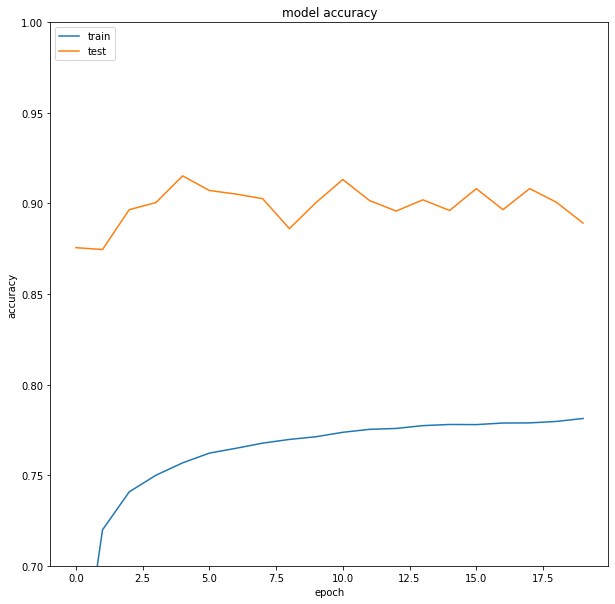

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.ylim(0.7,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

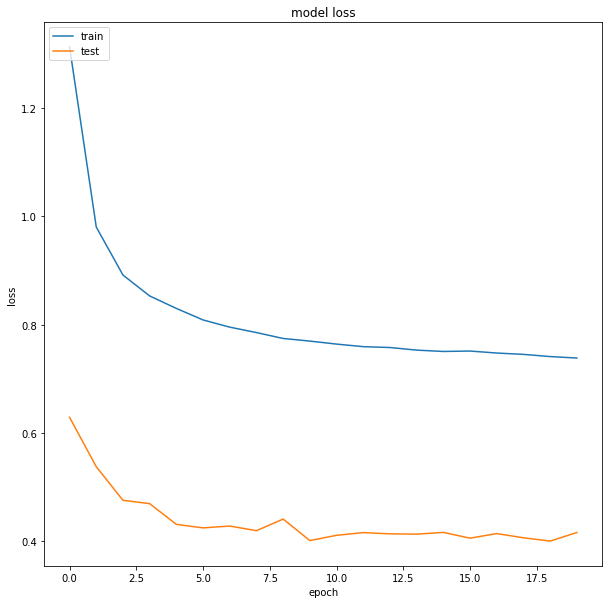

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
n = model.layers[1].get_weights()
sig = []

for i, (w, b) in enumerate(zip(n[0], n[1])):
    print('Node #{} weights:'.format(i))
    print('\tmin: {0:7.3f} at: {1:3}\n\tavg: {2:7.3f}\n\tmax: {3:7.3f} at: {4:3}'.format(np.amin(w), 
            np.argmin(w), np.average(w), np.amax(w), np.argmax(w)))
    print('Node #{0} bias: {1:7.3f}\n'.format(i, b))
    sig.append(np.argmin(w))
    sig.append(np.argmax(w))
    
print('Most common column for weight extrema:')
col = dataset.columns[1:19]
uniq, cnts = np.unique(sig, return_counts=True)
for (u, c) in zip(uniq, cnts):
    print('\tCol: {0:13s} Freq:{1:2d}'.format(col[u], c))
    
m_freq = np.argmax(cnts)
print('Most Freq. Col: {0:13s} Freq{1:2d}'.format(col[m_freq], cnts[m_freq]))

Node #0 weights:
	min:  -5.633 at:   1
	avg:   0.648
	max:   4.250 at:  12
Node #0 bias:   0.193

Node #1 weights:
	min: -16.257 at:   0
	avg:  -1.346
	max:   6.117 at:  12
Node #1 bias:  -0.006

Node #2 weights:
	min:  -0.051 at:   9
	avg:   0.002
	max:   0.046 at:  15
Node #2 bias:   0.034

Node #3 weights:
	min:  -0.013 at:   6
	avg:  -0.000
	max:   0.006 at:   5
Node #3 bias:   0.027

Node #4 weights:
	min: -18.860 at:   2
	avg:   0.226
	max:  14.271 at:  16
Node #4 bias:  -0.006

Node #5 weights:
	min:  -3.759 at:   3
	avg:   0.577
	max:   3.925 at:   7
Node #5 bias:   0.005

Node #6 weights:
	min: -11.882 at:  17
	avg:  -1.373
	max:   8.794 at:   1
Node #6 bias:   0.156

Node #7 weights:
	min:  -0.437 at:  10
	avg:  -0.054
	max:   0.196 at:  15
Node #7 bias:  -0.004

Node #8 weights:
	min:  -3.827 at:   0
	avg:  -0.210
	max:   0.250 at:  15
Node #8 bias:  -0.011

Node #9 weights:
	min: -16.697 at:   7
	avg:  -0.829
	max:  17.678 at:   3
Node #9 bias:   0.014

Node #10 weights:
	m

In [19]:
dataset_pred = dataset_NAS

Divide dataset hardware performance counters and labels

In [20]:
X_pred = dataset_pred.iloc[:,1:21].values
y_pred = dataset_pred.iloc[:,0].values

Normalize the data

In [21]:
X_pred_scaled = scaler_x.fit_transform(X_pred)

Use the network to predict the labels and transform the output to the pattern's labels

In [22]:
predictions = model.predict_classes(X_pred_scaled)
prediction_ = np.argmax(to_categorical(predictions), axis = 1)
prediction_ = encoder.inverse_transform(prediction_)

Classify the results in 'NAS pattern' predicted as: 'pattern (from patterns.csv)'

In [23]:
predicted_as={}
for i, j in zip(prediction_ , y_pred):
    pattern_as = str(j + " -- predicted as: " + i)
    if pattern_as not in predicted_as:
        predicted_as[pattern_as] = 0
    predicted_as[pattern_as] = predicted_as[pattern_as] + 1

Store and show results

In [24]:
with open('NAS-cleaned.txt', 'a+') as out:
    for i in sorted(predicted_as):
        print ( i , " --> ", predicted_as[i] )
        out.write(str(i) +  " --> " + str(predicted_as[i]) + "\n")
    out.write("--------------------------------------------------------------------------\n")

Add_BT -- predicted as: Add  -->  4623
Add_BT -- predicted as: Triad  -->  201
Scale_normztox -- predicted as: Add  -->  215
Scale_normztox -- predicted as: Scale  -->  1604
Scale_normztox -- predicted as: Stride4  -->  5
Triad_BT -- predicted as: Test  -->  24
Triad_Red_rhorr -- predicted as: 2D4PStencil  -->  1
Triad_Red_rhorr -- predicted as: Reduction  -->  1765
Triad_Red_rhorr -- predicted as: Stride2  -->  3
Triad_Red_rhorr -- predicted as: Test  -->  55
Triad_multi_z_alpha_p -- predicted as: 2D4PStencil  -->  26973
Triad_multi_z_alpha_p -- predicted as: Reduction  -->  107
Triad_multi_z_alpha_p -- predicted as: Test  -->  18141
Triad_multi_z_alpha_p -- predicted as: Triad  -->  379
Triad_norm_temps -- predicted as: Reduction  -->  1797
Triad_norm_temps -- predicted as: Test  -->  27
Triad_pr_beta_p -- predicted as: Stride2  -->  151
Triad_pr_beta_p -- predicted as: Triad  -->  45449
Triad_similar_l2norm -- predicted as: Test  -->  96
Triad_similar_qAp -- predicted as: Reduction 

Number of row with each pattern

In [25]:
df = pd.DataFrame(dataset_NAS, columns= ['label'])
df.pivot_table(index=['label'], aggfunc='size')

label
Add_BT                    4824
Scale_normztox            1824
Triad_BT                    24
Triad_Red_rhorr           1824
Triad_multi_z_alpha_p    45600
Triad_norm_temps          1824
Triad_pr_beta_p          45600
Triad_similar_l2norm        96
Triad_similar_qAp        45600
Triad_ssor_triad          6024
dtype: int64

In [26]:
#%%javascript
#Jupyter.notebook.session.delete();